
# No candidates problem



In [11]:
%matplotlib inline
from pylab import *
import numpy as np
from craco.search_pipeline import location2pix, get_grid_lut_from_plan, grid_candidates,wait_for_starts,waitall,print_candidates
from craco.search_pipeline import NBINARY_POINT_FDMTIN 
import craco
import craco.search_pipeline
from craco.pyxrtutil import *
import craft.craco_plan

from craft import uvfits

from craft.craco_plan import PipelinePlan
from craft.craco import printstats
import logging
import time

In [12]:
cd /CRACO/DATA_01/craco/SB067381/scans/00/20241101030549/injections

/CRACO/DATA_01/craco/SB067381/scans/00/20241101030549/injections


In [13]:
ls

boxcar_hist_iblk0.npy       mainbuf_iblk0_ib7.npy  mainbuf_iblk2_ib7.npy
boxcar_hist_iblk1.npy       mainbuf_iblk1_ib0.npy  plan_iblk12.pkl
boxcar_hist_iblk2.npy       mainbuf_iblk1_ib1.npy  plan_iblk18.pkl
candidates.b00.txt          mainbuf_iblk1_ib2.npy  plan_iblk24.pkl
flagging_stats_log_b00.csv  mainbuf_iblk1_ib3.npy  plan_iblk6.pkl
input_iblk0.npy             mainbuf_iblk1_ib4.npy  psf.beam00.iblk0.fits
input_iblk1.npy             mainbuf_iblk1_ib5.npy  psf.beam00.iblk12.fits
input_iblk2.npy             mainbuf_iblk1_ib6.npy  psf.beam00.iblk18.fits
input_iblk3.npy             mainbuf_iblk1_ib7.npy  psf.beam00.iblk24.fits
mainbuf_iblk0_ib0.npy       mainbuf_iblk2_ib0.npy  psf.beam00.iblk6.fits
mainbuf_iblk0_ib1.npy       mainbuf_iblk2_ib1.npy  rank_000_trace.json
mainbuf_iblk0_ib2.npy       mainbuf_iblk2_ib2.npy  RFI_tfmask.b00.fil
mainbuf_iblk0_ib3.npy       mainbuf_iblk2_ib3.npy  uv_data_iblk0.npy
mainbuf_iblk0_ib4.npy       mainbuf_iblk2_ib4.npy  uv_data_iblk1.npy
mainbuf_iblk0

In [81]:
input = np.load('input_iblk0.npy', allow_pickle=True)

In [82]:
input.shape

(253, 144, 256)

In [83]:
np.all(input == 0)

False

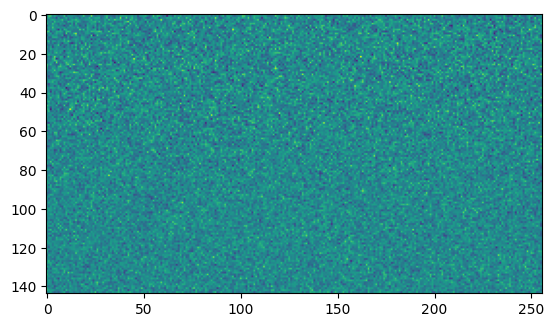

In [84]:
imshow(input[0,:,:].real)

In [85]:
uv_data = np.load('uv_data_iblk0.npy')

In [86]:
np.all(uv_data == 0)

False

In [87]:
uv_data.shape

(1024, 256, 32, 8, 2)

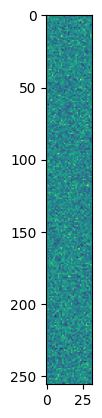

In [88]:
imshow(uv_data[0,:,:,0,0])

In [89]:
def load_mainbuf(iblk):
    names = [f'mainbuf_iblk{iblk:d}_ib{ib}.npy' for ib in range(8)]
    data = [np.load(n) for n in names]
    data = np.array(data)
    return data

In [90]:
mb0 = load_mainbuf(0)

In [91]:
mb0.shape # (nbuf, ?, ndm, nring, nt, nuvwide, ncomp)

(8, 43, 186, 5, 256, 8, 2)

In [92]:
np.all(mb0 == 0)

False

In [93]:
ls

boxcar_hist_iblk0.npy       mainbuf_iblk12_ib1.npy  mainbuf_iblk2_ib5.npy
boxcar_hist_iblk10.npy      mainbuf_iblk12_ib2.npy  mainbuf_iblk2_ib6.npy
boxcar_hist_iblk11.npy      mainbuf_iblk12_ib3.npy  mainbuf_iblk2_ib7.npy
boxcar_hist_iblk12.npy      mainbuf_iblk12_ib4.npy  mainbuf_iblk3_ib0.npy
boxcar_hist_iblk13.npy      mainbuf_iblk12_ib5.npy  mainbuf_iblk3_ib1.npy
boxcar_hist_iblk14.npy      mainbuf_iblk12_ib6.npy  mainbuf_iblk3_ib2.npy
boxcar_hist_iblk15.npy      mainbuf_iblk12_ib7.npy  mainbuf_iblk3_ib3.npy
boxcar_hist_iblk16.npy      mainbuf_iblk13_ib0.npy  mainbuf_iblk3_ib4.npy
boxcar_hist_iblk17.npy      mainbuf_iblk13_ib1.npy  mainbuf_iblk3_ib5.npy
boxcar_hist_iblk18.npy      mainbuf_iblk13_ib2.npy  mainbuf_iblk3_ib6.npy
boxcar_hist_iblk19.npy      mainbuf_iblk13_ib3.npy  mainbuf_iblk3_ib7.npy
boxcar_hist_iblk1.npy       mainbuf_iblk13_ib4.npy  mainbuf_iblk4_ib0.npy
boxcar_hist_iblk20.npy      mainbuf_iblk13_ib5.npy  mainbuf_iblk4_ib1.npy
boxcar_hist_iblk2.npy       mainbuf_ib

In [109]:
bc = np.load('boxcar_hist_iblk1.npy')


In [110]:
bc.shape

(1024, 7, 256, 256)

In [111]:
np.all(bc == 0)

False

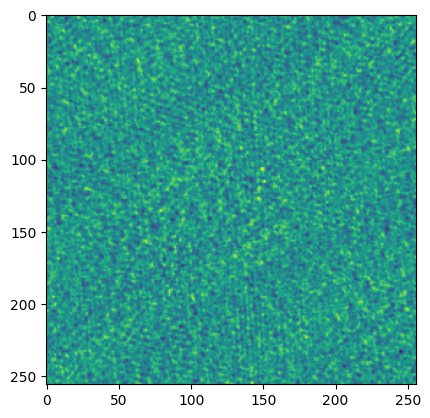

In [112]:
imshow(bc[0,0,:,:])

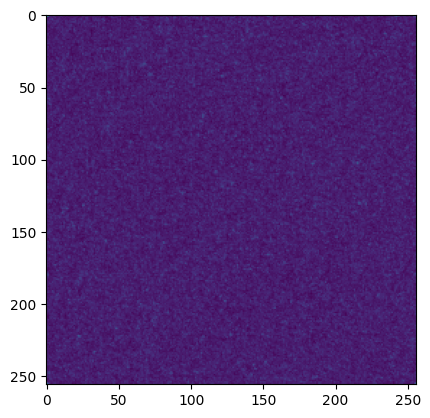

In [113]:
imshow(bc.max(axis=(0,1)))

In [114]:
idx = np.argmax(bc)
m = bc.flat[idx]
fidx = np.unravel_index(idx, bc.shape)
rms = bc[10,:,:,:].std()
print(f'Max {m} at {fidx} S/N={m/rms}')

Max 1780 at (10, 3, 0, 0) S/N=18.63942764999049


In [115]:
bc[fidx]

1780

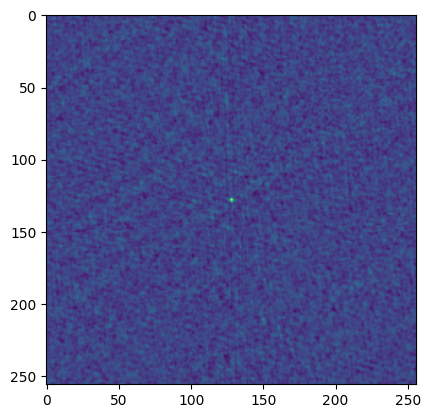

In [116]:
imshow(np.fft.fftshift(bc[10,3,:,:]))

In [121]:
bcserial = np.load('serial/boxcar_hist_iblk0.npy')

In [122]:
np.all(bc == bcserial)

True

In [179]:
def compare_serial_parallel_candidates():
    iblk = 2
    while True:
        try:
            candserial = np.load(f'serial/candidates_iblk{iblk-2}.npy')
            candbuf = np.load(f'candidate_buf_iblk{iblk-1}.npy')
            cand = np.load(f'candidates_iblk{iblk}.npy')
            ncand = len(candserial)
            nmin = min(len(candserial), len(cand))
            firstok = np.all(candserial[:nmin] == cand[:nmin])
            nbuf = count_candidates(candbuf)
            bufok = np.all(candbuf[:nbuf] == cand)
            print(f'Iblk {iblk} serial ={ncand}  parallel={len(cand)} {firstok} candbuf={count_candidates(candbuf)} {bufok} ')
            iblk += 1
        except FileNotFoundError:
            break


compare_serial_parallel_candidates()        
        

Iblk 2 serial =22  parallel=22 True candbuf=22 True 
Iblk 3 serial =141  parallel=141 True candbuf=141 True 
Iblk 4 serial =220  parallel=220 True candbuf=220 True 
Iblk 5 serial =186  parallel=186 True candbuf=186 True 
Iblk 6 serial =306  parallel=306 True candbuf=306 True 
Iblk 7 serial =287  parallel=279 False candbuf=279 True 
Iblk 8 serial =234  parallel=238 False candbuf=238 True 
Iblk 9 serial =242  parallel=245 False candbuf=245 True 
Iblk 10 serial =266  parallel=266 True candbuf=266 True 
Iblk 11 serial =291  parallel=291 True candbuf=291 True 
Iblk 12 serial =161  parallel=161 True candbuf=161 True 
Iblk 13 serial =132  parallel=120 False candbuf=120 True 
Iblk 14 serial =121  parallel=126 False candbuf=126 True 
Iblk 15 serial =95  parallel=96 False candbuf=96 True 
Iblk 16 serial =132  parallel=132 True candbuf=132 True 
Iblk 17 serial =148  parallel=148 True candbuf=148 True 
Iblk 18 serial =135  parallel=135 True candbuf=135 True 
Iblk 19 serial =76  parallel=72 False c

In [178]:
cand = np.load('candidates_iblk2.npy')
candserial = np.load('serial/candidates_iblk0.npy')
candbuf = np.load('candidate_buf_iblk1.npy')
candbuf.dtype
cand.shape

(22,)

In [170]:
cand.shape

(22,)

In [171]:
cand

array([(0, 0, 0, 0, 0), (0, 0, 0, 0, 0), (0, 0, 0, 0, 0), (0, 0, 0, 0, 0),
       (0, 0, 0, 0, 0), (0, 0, 0, 0, 0), (0, 0, 0, 0, 0), (0, 0, 0, 0, 0),
       (0, 0, 0, 0, 0), (0, 0, 0, 0, 0), (0, 0, 0, 0, 0), (0, 0, 0, 0, 0),
       (0, 0, 0, 0, 0), (0, 0, 0, 0, 0), (0, 0, 0, 0, 0), (0, 0, 0, 0, 0),
       (0, 0, 0, 0, 0), (0, 0, 0, 0, 0), (0, 0, 0, 0, 0), (0, 0, 0, 0, 0),
       (0, 0, 0, 0, 0), (0, 0, 0, 0, 0)],
      dtype=[('snr', '<i2'), ('loc_2dfft', '<u2'), ('boxc_width', 'u1'), ('time', 'u1'), ('dm', '<u2')])

In [147]:
def count_candidates(c):
    '''
    Count the number of candidates in a block of candiates by finding the first candidate with snr==0
    returns the index of that candidate. If there are no candidates in the block then returns len(c)
    '''
    try:
        ncand, lastcand = next((i,c) for i,c in enumerate(c) if c['snr']  == 0)
    except StopIteration:
        ncand = len(c) 

    return ncand

In [161]:
count_candidates(candbuf)

22

In [166]:
np.all(candserial == candbuf[:22])

True

In [156]:
cand

array([(0, 0, 0, 0, 0), (0, 0, 0, 0, 0), (0, 0, 0, 0, 0), (0, 0, 0, 0, 0),
       (0, 0, 0, 0, 0), (0, 0, 0, 0, 0), (0, 0, 0, 0, 0), (0, 0, 0, 0, 0),
       (0, 0, 0, 0, 0), (0, 0, 0, 0, 0), (0, 0, 0, 0, 0), (0, 0, 0, 0, 0),
       (0, 0, 0, 0, 0), (0, 0, 0, 0, 0), (0, 0, 0, 0, 0), (0, 0, 0, 0, 0),
       (0, 0, 0, 0, 0), (0, 0, 0, 0, 0), (0, 0, 0, 0, 0), (0, 0, 0, 0, 0),
       (0, 0, 0, 0, 0), (0, 0, 0, 0, 0)],
      dtype=[('snr', '<i2'), ('loc_2dfft', '<u2'), ('boxc_width', 'u1'), ('time', 'u1'), ('dm', '<u2')])

In [ ]:
bestidx = np.argmax(cand['snr'])

In [55]:
bestcand = cand[bestidx]
bestcand

(445, 0, 0, 252, 10)

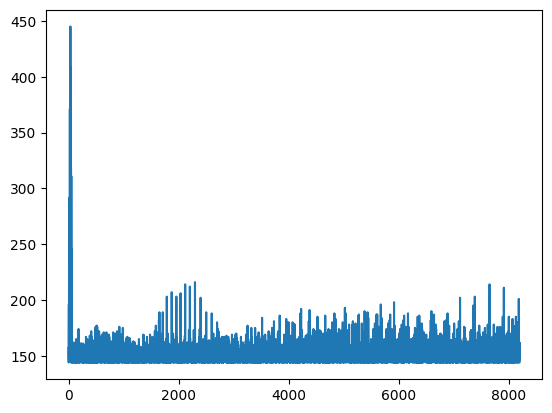

In [49]:
plot(cand['snr'])

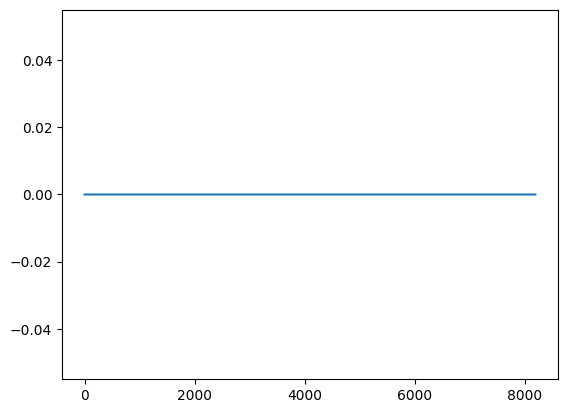

In [52]:
plot(cand['snr']==0)

In [56]:
cand.dtype

dtype([('snr', '<i2'), ('loc_2dfft', '<u2'), ('boxc_width', 'u1'), ('time', 'u1'), ('dm', '<u2')])

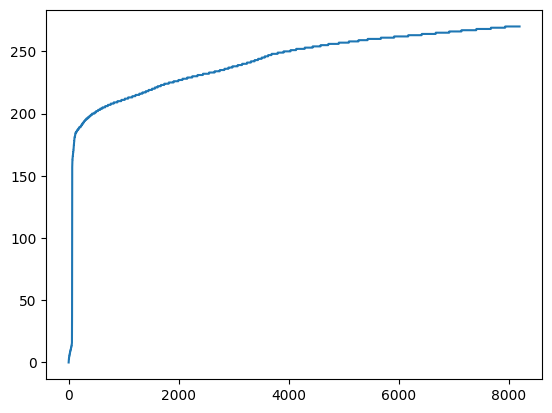

In [57]:
plot(cand['dm'])

In [59]:
cand2 = cand.copy()

In [77]:
cand2[-10]['snr'] = 0

In [78]:
stopidx, stopcand = first(enumerate(cand2), lambda idx,c: c['snr'] == 0)

In [80]:
next((i,c) for i,c in enumerate(cand) if c['snr']  == 0)

StopIteration: 

In [69]:
cand['snr']

array([157, 144, 177, ..., 162, 147, 148], dtype=int16)

In [71]:
stopcand['snr']

157